# Movie Recommendation System using Neural collaborative filtering on the MovieLens - 1M dataset.



### Team Members:
1.   Anuj Patel (amp10162)
2.   Harshal Kulkarni (hsk8171)
3.   Srushti Jagtap (sj4182)


# **Importing Libraries required**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!mkdir -p "/content/drive/My Drive/Colab Notebooks/Big Data"

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/Big Data")

!pwd

/content/drive/My Drive/Colab Notebooks/Big Data


In [ ]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
np.random.seed(123)
import seaborn as sns

from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql import Row
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

!pip install pytorch-lightning
import pytorch_lightning as pl

In [ ]:
# Initialize Spark session
spark = SparkSession.builder \
    .appName("MovieRecommendationSystem") \
    .getOrCreate()

# Load Data using Spark DataFrames
movies_meta = spark.read.option("delimiter", "::").csv("/content/drive/MyDrive/Colab Notebooks/Big Data/ml-1m/movies.dat", inferSchema=True)
movies_meta = movies_meta.toDF("MovieID", "Title", "Genres")

users = spark.read.option("delimiter", "::").csv("/content/drive/MyDrive/Colab Notebooks/Big Data/ml-1m/users.dat", inferSchema=True)
users = users.toDF("UserID", "Gender", "Age", "Occupation", "Zip-code")

ratings = spark.read.option("delimiter", "::").csv("/content/drive/MyDrive/Colab Notebooks/Big Data/ml-1m/ratings.dat", inferSchema=True)
ratings = ratings.toDF("UserID", "MovieID", "Rating", "Timestamp")

# Preprocessing - Convert to Pandas DataFrame for PyTorch
ratings_pd = ratings.select("UserID", "MovieID", "Rating").toPandas()

# Normalize the ratings (you can also use MinMaxScaler or StandardScaler)
ratings_pd['Rating'] = ratings_pd['Rating'] / 5.0  # Scale ratings to [0, 1]

# Train-Test Split
train_data, test_data = train_test_split(ratings_pd, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
train_tensor = torch.tensor(train_data[['UserID', 'MovieID']].values, dtype=torch.long)
train_ratings = torch.tensor(train_data['Rating'].values, dtype=torch.float32)

test_tensor = torch.tensor(test_data[['UserID', 'MovieID']].values, dtype=torch.long)
test_ratings = torch.tensor(test_data['Rating'].values, dtype=torch.float32)

# Create DataLoader for batch processing
train_dataset = TensorDataset(train_tensor, train_ratings)
test_dataset = TensorDataset(test_tensor, test_ratings)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)



In [ ]:
# Display the first 5 rows of the DataFrame in a readable format
movies_meta.show(5)

+-------+--------------------+--------------------+
|MovieID|               Title|              Genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Animation|Childre...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|        Comedy|Drama|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows



In [ ]:
# Display the first 5 rows of the DataFrame in a readable format
users.show(5)

+------+------+---+----------+--------+
|UserID|Gender|Age|Occupation|Zip-code|
+------+------+---+----------+--------+
|     1|     F|  1|        10|   48067|
|     2|     M| 56|        16|   70072|
|     3|     M| 25|        15|   55117|
|     4|     M| 45|         7|   02460|
|     5|     M| 25|        20|   55455|
+------+------+---+----------+--------+
only showing top 5 rows



In [ ]:
# Display the first 5 rows of the DataFrame in a readable format
ratings.show(5)

+------+-------+------+---------+
|UserID|MovieID|Rating|Timestamp|
+------+-------+------+---------+
|     1|   1193|     5|978300760|
|     1|    661|     3|978302109|
|     1|    914|     3|978301968|
|     1|   3408|     4|978300275|
|     1|   2355|     5|978824291|
+------+-------+------+---------+
only showing top 5 rows



# **Data Visualization**

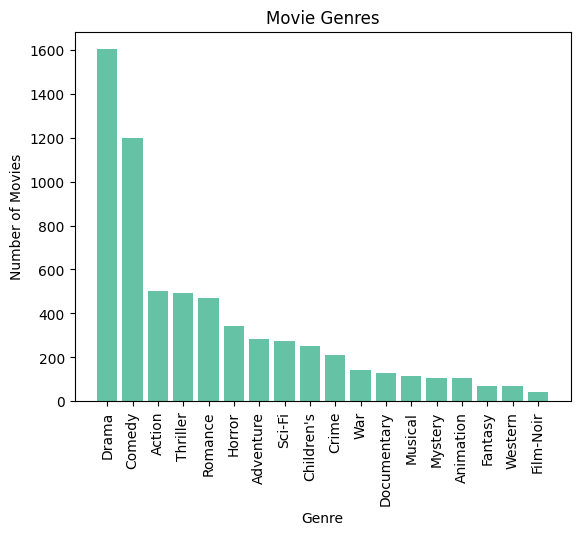

In [ ]:
# Convert Spark DataFrame to Pandas DataFrame
movies_meta_pd = movies_meta.toPandas()

# Now proceed with the code as before
import matplotlib.pyplot as plt

# create a bar graph of movie genres
genres = movies_meta_pd['Genres'].str.split('|', expand=True).stack().value_counts()
plt.bar(genres.index, genres.values)
plt.xticks(rotation=90)
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.title('Movie Genres')
plt.show()



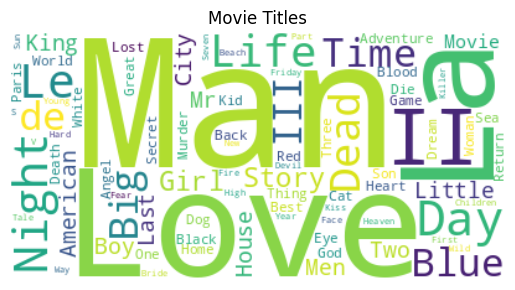

In [ ]:
# create a word cloud of movie titles
from wordcloud import WordCloud

# join all movie titles into a single string
titles = ' '.join(movies_meta_pd['Title'].tolist())

# generate word cloud
wordcloud = WordCloud(background_color='white').generate(titles)

# display the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Movie Titles')
plt.show()

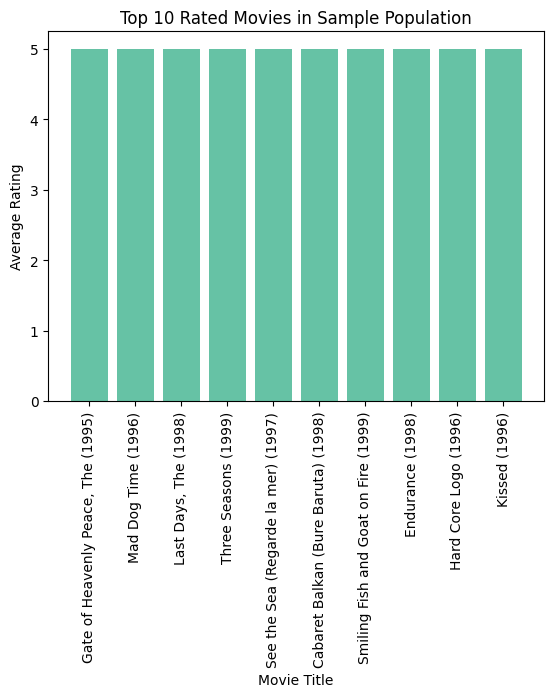

In [ ]:
from pyspark.sql import functions as F

# Merge the ratings and movies metadata DataFrames using Spark join
merged_data = ratings.join(movies_meta, on='MovieID', how='inner')

# Get a random sample of the merged dataset
sample = merged_data.sample(fraction=0.1, seed=42)  # 10% sample of data

# Calculate the average rating for each movie in the sample
avg_ratings = sample.groupBy('Title').agg(F.avg('Rating').alias('avg_rating'))

# Sort by average rating and get the top 10 rated movies
top_10_rated_movies = avg_ratings.orderBy(F.desc('avg_rating')).limit(10)

# Convert to Pandas for plotting
top_10_rated_movies_pd = top_10_rated_movies.toPandas()

# Plot the bar graph
plt.bar(top_10_rated_movies_pd['Title'], top_10_rated_movies_pd['avg_rating'])
plt.xticks(rotation=90)
plt.xlabel('Movie Title')
plt.ylabel('Average Rating')
plt.title('Top 10 Rated Movies in Sample Population')
plt.show()


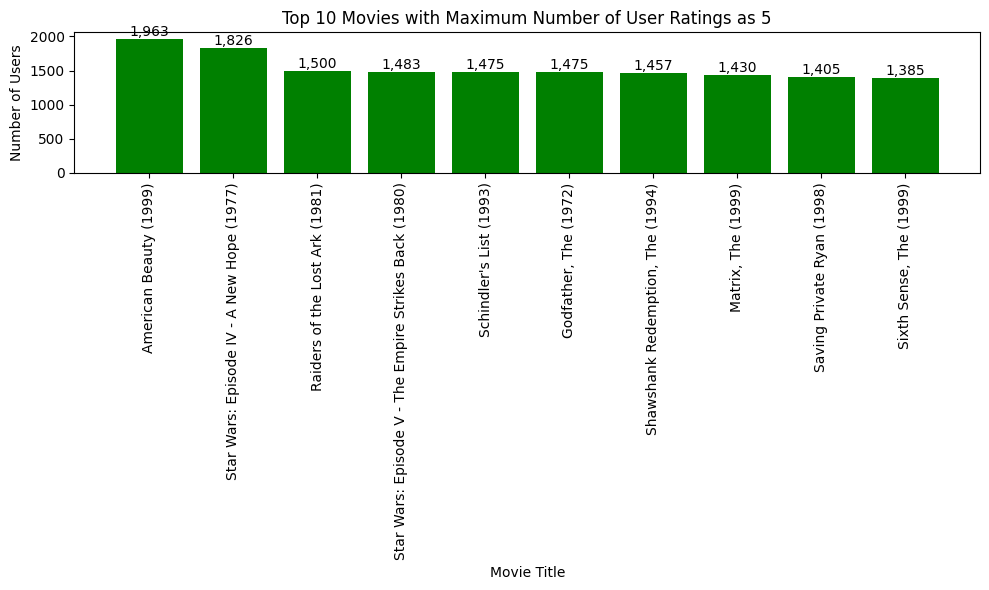

In [ ]:
# Merge the movies and ratings DataFrames using the movie-id as the common column
merged_df = ratings.join(movies_meta, on='MovieID', how='inner')

# Filter the merged DataFrame to only include movies with a rating of 5
filtered_df = merged_df.filter(merged_df['Rating'] == 5)

# Group by MovieID and count the number of unique UserIDs for each movie
grouped_df = filtered_df.groupBy('MovieID').agg(F.countDistinct('UserID').alias('num_users'))

# Get the top 10 movies with the highest number of users
top_10_movies = grouped_df.orderBy(F.desc('num_users')).limit(10)

# Join the top 10 movies with the movies_meta to get the titles and genres
result = top_10_movies.join(movies_meta, on='MovieID', how='inner').select('Title', 'Genres', 'num_users')

# Convert to Pandas for plotting
result_pd = result.toPandas()

# Sort the result in descending order by the number of users
result_pd = result_pd.sort_values(by='num_users', ascending=False)

# Plot the graph
plt.figure(figsize=(10, 6))
bars = plt.bar(result_pd['Title'], result_pd['num_users'], color='green')

# Annotate each bar with the value on top
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f'{bar.get_height():,.0f}',
             ha='center', va='bottom', fontsize=10)

plt.xticks(rotation=90)
plt.xlabel('Movie Title')
plt.ylabel('Number of Users')
plt.title('Top 10 Movies with Maximum Number of User Ratings as 5')
plt.tight_layout()
plt.show()


In [ ]:
# Merge the ratings and movies metadata using Spark's join method
merged_data = ratings.join(movies_meta, on='MovieID', how='inner')

# Filter movies with rating 5
rating_5_movies = merged_data.filter(merged_data['Rating'] == 5)

# Count the number of unique movies with rating 5
count = rating_5_movies.select('MovieID').distinct().count()

print("Number of movies with rating 5: ", count)


Number of movies with rating 5:  3232


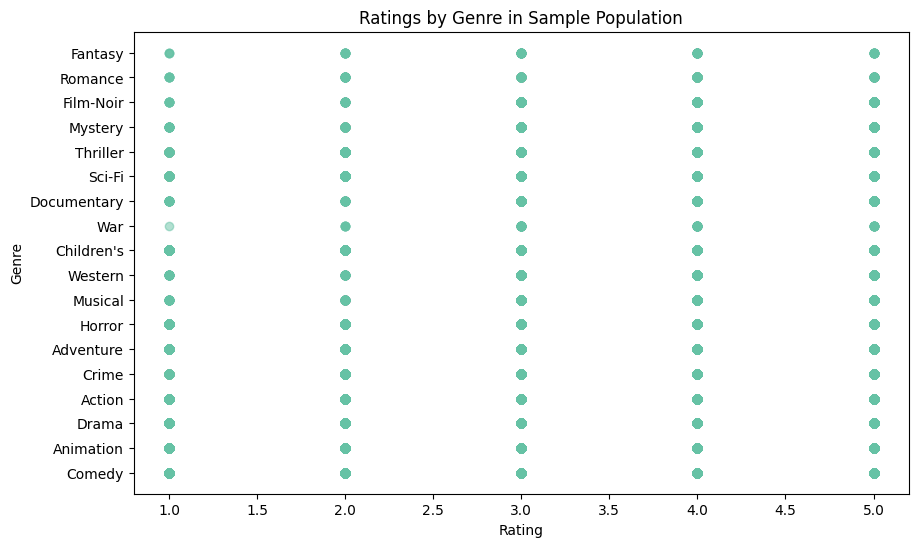

In [ ]:
# Split the 'Genres' column and create a new 'primary_genre' column
movies_meta = movies_meta.withColumn('primary_genre', F.split(movies_meta['Genres'], '\|').getItem(0))

# Join the sample with movies_meta on 'MovieID' to get the primary genre
sample_with_genre = sample.join(movies_meta[['MovieID', 'primary_genre']], on='MovieID', how='inner')

# Collect the data to Pandas DataFrame for plotting
sample_with_genre_pd = sample_with_genre.select('Rating', 'primary_genre').toPandas()

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(sample_with_genre_pd['Rating'], sample_with_genre_pd['primary_genre'], alpha=0.5)
plt.xlabel('Rating')
plt.ylabel('Genre')
plt.title('Ratings by Genre in Sample Population')
plt.show()


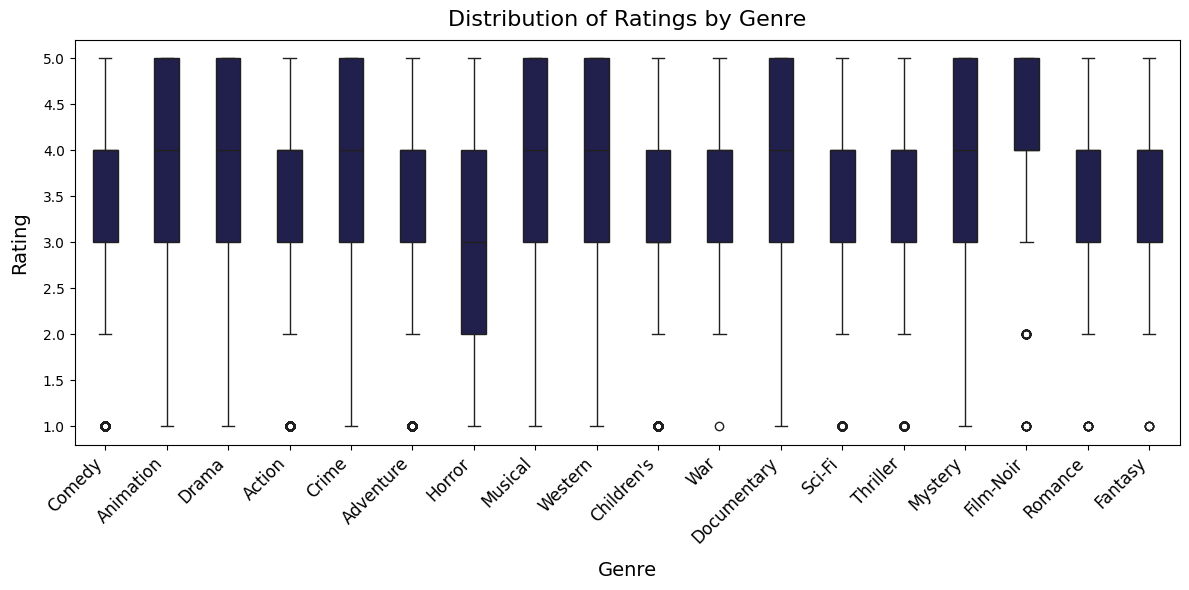

In [ ]:
# Collect data to pandas DataFrame for plotting
sample_with_genre_pd = sample_with_genre.select('Rating', 'primary_genre').toPandas()

# Set the figure size for better visibility
plt.figure(figsize=(12, 6))

# Set a color palette for better aesthetics
sns.set_palette("Set2")

# Create a box plot with improved appearance
sns.boxplot(x='primary_genre', y='Rating', data=sample_with_genre_pd, color='#1a1852', width=0.4)

# Improve labels and title
plt.xlabel('Genre', fontsize=14, labelpad=10)
plt.ylabel('Rating', fontsize=14, labelpad=10)
plt.title('Distribution of Ratings by Genre', fontsize=16, pad=10)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=12)

# Adjust the layout to ensure everything fits
plt.tight_layout()

# Display the plot
plt.show()


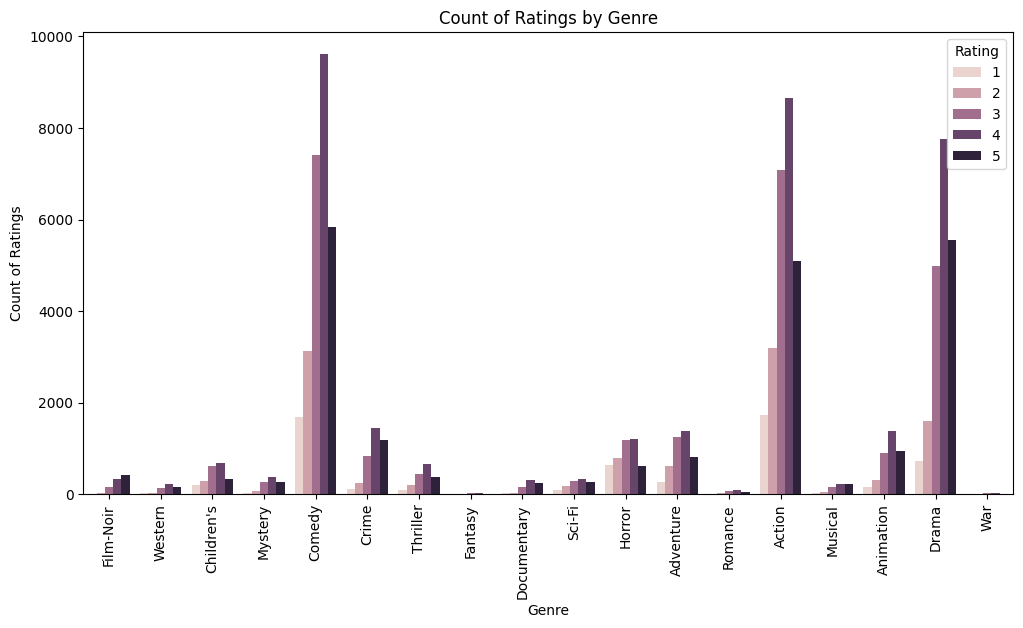

In [ ]:
# Group by genre and rating, and count the occurrences of each rating
rating_counts = sample_with_genre.groupBy('primary_genre', 'Rating').count()

# Convert to Pandas for plotting
rating_counts_pd = rating_counts.toPandas()

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='primary_genre', y='count', hue='Rating', data=rating_counts_pd)
plt.xlabel('Genre')
plt.ylabel('Count of Ratings')
plt.title('Count of Ratings by Genre')
plt.xticks(rotation=90)
plt.legend(title='Rating', loc='upper right')
plt.show()


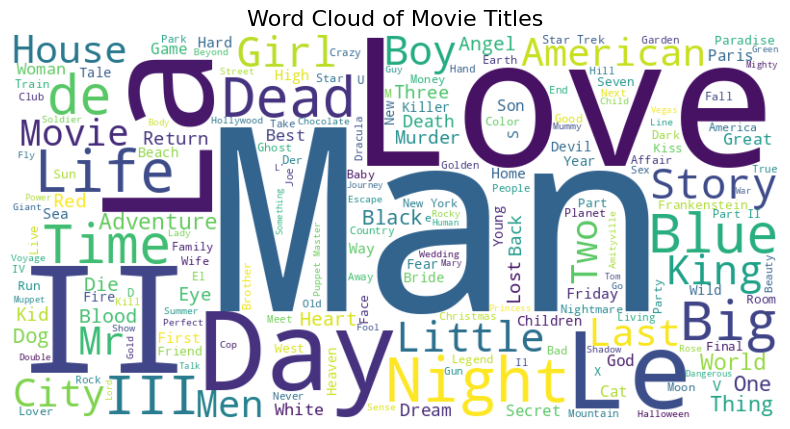

In [ ]:
from wordcloud import WordCloud
# Collect all titles from the Spark DataFrame
all_titles = " ".join(movies_meta.select("Title").rdd.flatMap(lambda x: x).collect())

# Create and configure the WordCloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_titles)

# Plot the WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Movie Titles", fontsize=16)
plt.show()


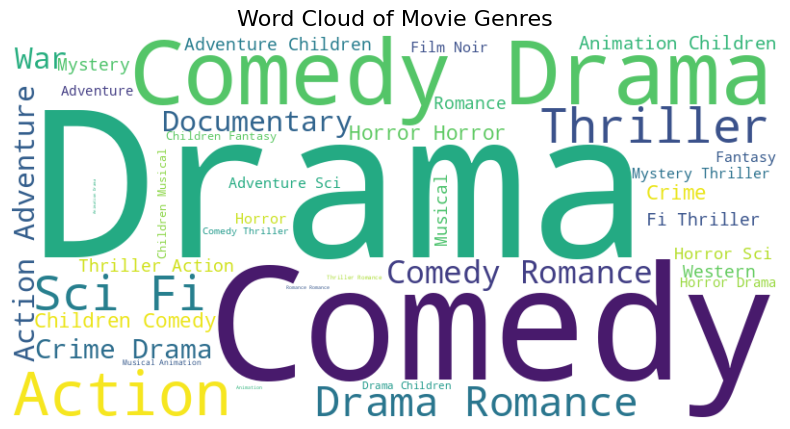

In [ ]:
# Collect all genres from the Spark DataFrame
all_genres = " ".join(movies_meta.select("Genres").rdd.flatMap(lambda x: x).collect())

# Create and configure the WordCloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_genres)

# Plot the WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Movie Genres", fontsize=16)
plt.show()


# **Train and Test Data**



In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Rank ratings based on the latest timestamp per user
ratings = ratings.withColumn(
    "rank_latest",
    F.rank().over(Window.partitionBy("UserID").orderBy(F.desc("Timestamp")))
)

# Split data into training and testing datasets
train_ratings = ratings.filter(F.col("rank_latest") != 1)
test_ratings = ratings.filter(F.col("rank_latest") == 1)

# Drop unnecessary columns in training and testing datasets
train_ratings = train_ratings.select("UserID", "MovieID", F.lit(1).alias("Rating"))
test_ratings = test_ratings.select("UserID", "MovieID", "Rating")

# Show a sample of the training data
train_ratings.show(5)


+------+-------+------+
|UserID|MovieID|Rating|
+------+-------+------+
|     1|   1566|     1|
|     1|   1907|     1|
|     1|   2355|     1|
|     1|   2294|     1|
|     1|    783|     1|
+------+-------+------+
only showing top 5 rows



In [ ]:
# Convert PySpark DataFrame to Pandas
train_ratings_pd = train_ratings.toPandas()
test_ratings_pd = test_ratings.toPandas()
ratings = ratings.toPandas()


In [ ]:
ratings['Timestamp'] = ratings['Timestamp']
ratings['rank_latest'] = ratings.groupby(['UserID'])['Timestamp'] \
                                .rank(method='first', ascending=False)

# Splitting the data into training and testing data where rank either equal or not equal to 1
train_ratings = ratings[ratings['rank_latest'] != 1]
test_ratings = ratings[ratings['rank_latest'] == 1]

# drop columns that we no longer need which is timestamp since splitting is over
train_ratings = train_ratings[['UserID', 'MovieID', 'Rating']]
test_ratings = test_ratings[['UserID', 'MovieID', 'Rating']]

train_ratings.loc[:, 'Rating'] = 1

train_ratings.sample(5)

,UserID,MovieID,Rating
585884,1018,3421,1
857618,4250,1304,1
200300,2484,2336,1
523706,301,318,1
696192,2254,1385,1


In [ ]:
#Generating random negative values (0) for each positive interaction (1) on the ratio of 4:1

# Get a list of all movie IDs
all_movieIds = ratings['MovieID'].unique()

# Placeholders that will hold the training data
users, items, labels = [], [], []

# This is the set of items that each user has interaction with
user_item_set = set(zip(train_ratings['UserID'], train_ratings['MovieID']))

# 4:1 ratio of negative to positive samples
num_negatives = 4

for (u, i) in tqdm(user_item_set):
    users.append(u)
    items.append(i)
    labels.append(1) # items that the user has interacted with are positive
    for _ in range(num_negatives):
        # randomly select an item
        negative_item = np.random.choice(all_movieIds)
        # check that the user has not interacted with this item
        while (u, negative_item) in user_item_set:
            negative_item = np.random.choice(all_movieIds)
        users.append(u)
        items.append(negative_item)
        labels.append(0) # items not interacted with are negative

  0%|          | 0/994169 [00:00<?, ?it/s]

# Creating a class to generate tensors of user and item entires

In [ ]:
class MovieLensTrainDataset(Dataset):
    """MovieLens PyTorch Dataset for Training

    Args:
        ratings (pd.DataFrame): Dataframe containing the movie ratings
        all_movieIds (list): List containing all movieIds

    """

    def __init__(self, ratings, all_movieIds):
        self.users, self.items, self.labels = self.get_dataset(ratings, all_movieIds)

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.labels[idx]

    def get_dataset(self, ratings, all_movieIds):
        users, items, labels = [], [], []
        user_item_set = set(zip(ratings['UserID'], ratings['MovieID']))

        num_negatives = 4
        for u, i in user_item_set:
            users.append(u)
            items.append(i)
            labels.append(1)
            for _ in range(num_negatives):
                negative_item = np.random.choice(all_movieIds)
                while (u, negative_item) in user_item_set:
                    negative_item = np.random.choice(all_movieIds)
                users.append(u)
                items.append(negative_item)
                labels.append(0)

        return torch.tensor(users),torch.tensor(items),torch.tensor(labels)

# Creating a class to process the pytorch lightning model

In [ ]:
class NCF(pl.LightningModule):
    """ Neural Collaborative Filtering (NCF)

        Args:
            num_users (int): Number of unique users
            num_items (int): Number of unique items
            ratings (pd.DataFrame): Dataframe containing the movie ratings for training
            all_movieIds (list): List containing all movieIds (train + test)
    """

    def __init__(self, num_users, num_items, ratings, all_movieIds):
        super().__init__()
        self.user_embedding = nn.Embedding(num_embeddings=num_users, embedding_dim=8)
        self.item_embedding = nn.Embedding(num_embeddings=num_items, embedding_dim=8)
        self.fc1 = nn.Linear(in_features=16, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=32)
        self.output = nn.Linear(in_features=32, out_features=1)
        self.ratings = ratings
        self.all_movieIds = all_movieIds

    def forward(self, user_input, item_input):

        # Pass through embedding layers
        user_embedded = self.user_embedding(user_input)
        item_embedded = self.item_embedding(item_input)

        # Concat the two embedding layers
        vector = torch.cat([user_embedded, item_embedded], dim=-1)

        # Pass through dense layer
        vector = nn.ReLU()(self.fc1(vector))
        vector = nn.ReLU()(self.fc2(vector))

        # Output layer
        pred = nn.Sigmoid()(self.output(vector))

        return pred

    def training_step(self, batch, batch_idx):
        user_input, item_input, labels = batch
        predicted_labels = self(user_input, item_input)
        loss = nn.BCELoss()(predicted_labels, labels.view(-1, 1).float())
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

    def train_dataloader(self):
        return  DataLoader(MovieLensTrainDataset (self.ratings,self.all_movieIds), batch_size=512, num_workers=2)


In [ ]:
num_users = (ratings['UserID'].max()+1)
num_items = (ratings['MovieID'].max()+1)

all_movieIds = ratings['MovieID'].unique()

model = NCF(num_users, num_items, train_ratings, all_movieIds)

In [ ]:
# Training our NCF model for 50 epochs using the GPU.
model = model.to('cuda')
trainer = pl.Trainer(max_epochs= 10, logger=False)
# gpus=1, reload_dataloaders_every_epoch=True, progress_bar_refresh_rate=50,checkpoint_callback=False
trainer.fit(model)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/drive/MyDrive/Colab Notebooks/Big Data/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type      | Params | Mode 
-----------------------------------------------------
0 | user_embedding | Embedding | 48.3 K | train
1 | item_embedding | Embedding | 31.6 K | train
2 | fc1            | Linear    | 1.1 K  | train
3 | fc2            | Linear    | 2.1 K  | train
4 | output         | Linear    | 33     | train
-----------------------------------------------------
83.2 K    Trainable params
0 

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
file_path = "mrs-v4.pkl"
torch.save(model.state_dict(), file_path)

In [ ]:
# User-item pairs for testing
test_user_item_set = set(zip(test_ratings['UserID'], test_ratings['MovieID']))

# Dict of all items that are interacted with by each user
user_interacted_items = ratings.groupby('UserID')['MovieID'].apply(list).to_dict()

hits = []
for (u,i) in tqdm(test_user_item_set):
    interacted_items = user_interacted_items[u]
    not_interacted_items = set(all_movieIds) - set(interacted_items)
    selected_not_interacted = list(np.random.choice(list(not_interacted_items), 99))
    test_items = selected_not_interacted + [i]

    predicted_labels = np.squeeze(model(torch.tensor([u]*100),
                                        torch.tensor(test_items)).detach().numpy())

    top10_items = [test_items[i] for i in np.argsort(predicted_labels)[::-1][0:10].tolist()]

    if i in top10_items:
        hits.append(1)
    else:
        hits.append(0)

print("The Hit Ratio @ 10 is {:.2f}".format(np.average(hits)))

  0%|          | 0/6040 [00:00<?, ?it/s]

The Hit Ratio @ 10 is 0.49


In [ ]:
print(hits), len(hits)

[0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 

(None, 6040)

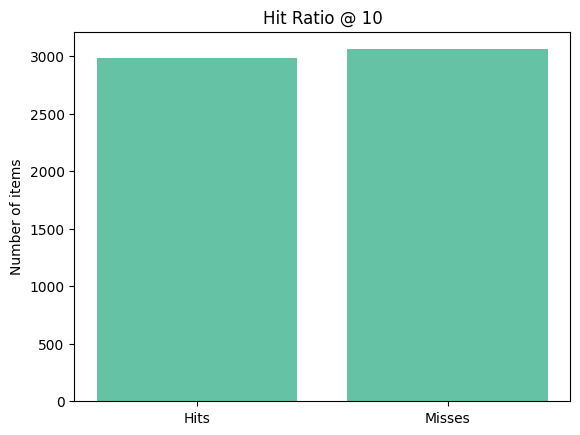

In [ ]:
#graphically understanding the number of hits
# Count the number of hits and misses
num_hits = sum(hits)
num_misses = len(hits) - num_hits

# Create a bar chart
plt.bar(['Hits', 'Misses'], [num_hits, num_misses])
plt.title('Hit Ratio @ 10')
plt.ylabel('Number of items')
plt.show()


In [ ]:
print(top10_items)

[587, 1200, 3450, 3107, 3534, 1204, 3, 1299, 1235, 2468]


In [ ]:
movies_meta_pandas = movies_meta.toPandas()

id2title = dict(zip(movies_meta_pandas["MovieID"], movies_meta_pandas["Title"]))
id2info = dict(zip(movies_meta_pandas["MovieID"],
                   zip(movies_meta_pandas["Title"], movies_meta_pandas["Genres"])))


In [ ]:
# Iterate through the top 10 items in each hit and print their titles and genres
for (u, i) in tqdm(test_user_item_set):
    interacted_items = user_interacted_items[u]
    not_interacted_items = set(all_movieIds) - set(interacted_items)
    selected_not_interacted = list(np.random.choice(list(not_interacted_items), 99))
    test_items = selected_not_interacted + [i]

    predicted_labels = np.squeeze(model(torch.tensor([u]*100),
                                        torch.tensor(test_items)).detach().numpy())

    top10_items = [test_items[i] for i in np.argsort(predicted_labels)[::-1][0:10].tolist()]

    if i in top10_items:
        hits.append(1)
        # Get top 10 titles and genres
        top10_info = [id2info[item] for item in top10_items]
        print(f"\nUser {u}, recommended movie '{id2info[i][0]}' (Genre: {id2info[i][1]}) was a hit!")
        print("Top 10 recommended movies:")
        for title, genre in top10_info:
            print(f"{title} (Genre: {genre})")
    else:
        hits.append(0)


  0%|          | 0/6040 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
Ferris Bueller's Day Off (1986) (Genre: Comedy)
Indiana Jones and the Last Crusade (1989) (Genre: Action|Adventure)
Chicken Run (2000) (Genre: Animation|Children's|Comedy)
Pretty in Pink (1986) (Genre: Comedy|Drama|Romance)
Leaving Las Vegas (1995) (Genre: Drama|Romance)
Blues Brothers, The (1980) (Genre: Action|Comedy|Musical)
Air Force One (1997) (Genre: Action|Thriller)
Fantasia (1940) (Genre: Animation|Children's|Musical)

User 5338, recommended movie 'Coneheads (1993)' (Genre: Comedy|Sci-Fi) was a hit!
Top 10 recommended movies:
Con Air (1997) (Genre: Action|Adventure|Thriller)
L.A. Confidential (1997) (Genre: Crime|Film-Noir|Mystery|Thriller)
Gone in 60 Seconds (2000) (Genre: Action|Crime)
Airplane! (1980) (Genre: Comedy)
Coneheads (1993) (Genre: Comedy|Sci-Fi)
Cape Fear (1991) (Genre: Thriller)
Avengers, The (1998) (Genre: Action|Adventure)
Sleepless in Seattle (1993) (Genre: Comedy|Romance)
Tombstone (1993) (Genre: Western)
Sha

In [ ]:
# Stop Spark session when done
spark.stop()

# Using Streamlit to create a dashboard

In [ ]:
!pip install pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 31.4 MB/s eta 0:00:00


In [ ]:
! pip install streamlit -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 77.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.2 MB/s eta 0:00:00


In [ ]:
!wget -q -O - ipv4.icanhazip.com

34.23.120.5


In [ ]:
! streamlit run app.py & npx localtunnel --port 8501




⠙⠹⠸⠼⠴
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.23.120.5:8501

⠦⠧your url is: https://salty-impalas-shout.loca.lt
2024-12-06 03:06:31.902 Examining the path of torch.classes raised: Tried to instantiate class '__path__._path', but it does not exist! Ensure that it is registered via torch::class_
  Stopping...
^C
